## Toy Example 

Here, we provide code that reproduces the toy example in our paper. Please read the toy example setting in the paper. <br>

In short:
+ We consider a 2D synthetic example where a linear classifier $z = Wx$ is deployed to solve a 3-class classification problem. In our case, the weight matrix is: $$ W = \begin{bmatrix} 0.3 &-0.3 \\ 1 & -0.01 \\ -0.25 & 0.75  \end{bmatrix} $$
+ We avoid to empasize unecessary (for our purpose) details, like what is the data distribution or the training examples. We suppose that this classifier solves adequately well a 2D 3-ary classification problem.
+ At inference time, a point $x = (-0.45,-0.8)$ coming from the first ground truth class $y_1$ is fed to the classifier and the model assigns to it the correct label. Our goal is to generate an $\ell_2$-bounded perturbation $\delta$ (with $\|\delta\|_2 = 0.7$) which can alter the classifier's decision on the $x+\delta$. To this end, we deploy PGD with 3 different options for the surrogate loss.

Essentially, this toy example acts as an intuitive explanation on why the alternation of objectives may be more robust in comparison with the single-loss variants.

In [1]:
import numpy as np
from math import sqrt, exp, cos, sin as sqrt,exp,cos,sin
import matplotlib.pyplot as plt
import torch

PI = np.pi

In [2]:
def PGD_step(x, x_clean, eps, alpha, loss):

    #loss = loss_fn(x[0],x[1])
    loss.backward()
    x_grad_l2 = torch.norm(x.grad,p=2)
    
    # follows the normalized gradient step
    x_next = torch.tensor(x+alpha*x.grad/x_grad_l2, requires_grad=True)
    
    # project the perturbation onto the lp-ball of radius eps aroux the clean input x
    dist = torch.norm(x_next-x_clean,p=2).item()
    if dist > eps:
        delta = x_next-x_clean
        delta = eps*delta/dist
        x_next = torch.tensor(x_clean+delta, requires_grad=True)
        
    return x_next

In [3]:
def clf_loss(x,w1,w2,w3):
    '''
    Calculates the classifier's loss 
    '''
    # calculate logits
    z1 = w1[0]*x[0] + w1[1]*x[1]
    z2 = w2[0]*x[0] + w2[1]*x[1]
    z3 = w3[0]*x[0] + w3[1]*x[1]
    
    # calculate ce and cw losses based on logits
    ce = -z1 + torch.log(torch.exp(z1)+torch.exp(z2)+torch.exp(z3))
    cw = -z1 + torch.max(z2,z3)
    
    return {'CE': ce, 'CW': cw}

Now, we will execute PGD with three options: 
+ CE loss for T=50,
+ CW loss for T=50,
+ CE loss for T=25 iterations followed by an equal amount of iterations for the CW loss.

In [4]:
w1, w2, w3 = (0.3,-0.3), (1,-0.01), (-0.25,0.75) 
x0, y0 = (-0.45, -0.8)
x_clean = torch.tensor([x0,y0])
eps = 0.7 
alpha = eps/2

x_ce = torch.tensor(x_clean.clone(), requires_grad=True)
points_ce = np.array(x_ce.data.detach().clone().numpy())

x_cw = torch.tensor(x_clean.clone(), requires_grad=True)
points_cw = np.array(x_cw.data.detach().clone().numpy())

x_cwce = torch.tensor(x_clean.clone(), requires_grad=True)
points_cwce = np.array(x_cwce.data.detach().clone().numpy())

T = 50 
for t in range(T):
    ce = clf_loss(x_ce, w1, w2, w3)['CE']
    cw = clf_loss(x_cw, w1, w2, w3)['CW']
    cwce = clf_loss(x_cwce, w1, w2, w3)['CW'] if t < T/2 else clf_loss(x_cwce, w1, w2, w3)['CE']
    
    x_ce = PGD_step(x_ce, x_clean, eps, alpha, ce)
    x_cw = PGD_step(x_cw, x_clean, eps, alpha, cw)
    x_cwce = PGD_step(x_cwce, x_clean, eps, alpha, cwce)
    
    # hold the points to visualize them later
    points_ce = np.vstack((points_ce,x_ce.detach().clone().numpy()))
    points_cw = np.vstack((points_cw,x_cw.detach().clone().numpy()))
    points_cwce = np.vstack((points_cwce,x_cwce.detach().clone().numpy()))

/home/anicko/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/anicko/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/anicko/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/anicko/anaconda3/envs/py37/lib/python3.7/site-packages/ipyker

Now, we proceed to the visualization part. First, we find the decision boundaries of the linear classifier of our experiment as follows:

In [5]:
x1 = np.linspace(-2, 2, 500)
x2 = np.linspace(-2, 2, 500)

def z1(x1,x2):
    return w1[0]*x1+w1[1]*x2

def z2(x1,x2):
    return w2[0]*x1+w2[1]*x2

def z3(x1,x2):
    return w3[0]*x1+w3[1]*x2

X1, X2 = np.meshgrid(x1, x2)
X1, X2 = X1, X2[::-1]

z1_win = np.logical_and((z1(X1,X2) > z2(X1,X2)),(z1(X1,X2) > z3(X1,X2)))
z2_win = np.logical_and((z2(X1,X2) > z1(X1,X2)),(z2(X1,X2) > z3(X1,X2)))
z3_win = np.logical_and((z3(X1,X2) > z1(X1,X2)),(z3(X1,X2) > z2(X1,X2)))

pl = np.ones((500,500))
pl[z2_win] = 2 # when z2 wins, pl is 2 
pl[z3_win] = 3 # when z3 wins, pl is 3 
# this leaves 1 on points where z1 wins

Here, we plot the intermediate PGD steps for the first two cases, where the PGD uses a single loss throughout the whole process. 

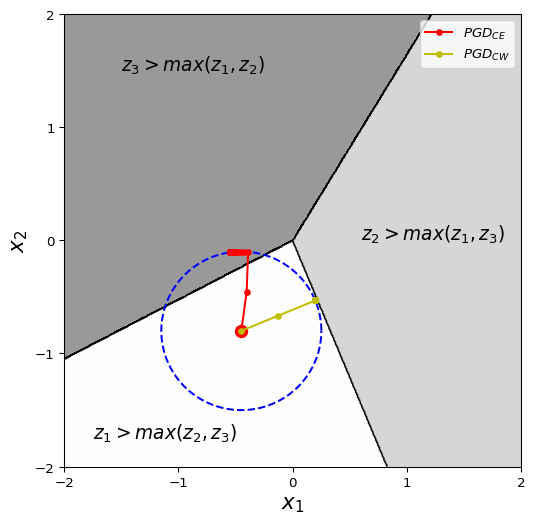

In [6]:
# this is for plotting purposes 
circle = np.array([[0,0]])
eps = 0.7 

for theta in np.arange(0,2*PI,0.01):
    points = np.array([[eps*cos(theta)+x0,eps*sin(theta)+y0]])
    circle = np.vstack((circle,points))
circle = circle[1:]

my_dpi = 96
plt.figure(figsize=(590/my_dpi,600/my_dpi), dpi=my_dpi)

col_bar = plt.contourf(X1, X2, pl, 60, cmap='Greys', alpha=0.4);
plt.contour(col_bar, cmap=None , levels=[0,1,2,3,4], colors='k', linewidths=(1,));
    
plt.plot(x0,y0,'ro',markersize=9);
plt.plot(circle[:,0],circle[:,1],'b--',markersize=6);
plt.plot(points_ce[:,0],points_ce[:,1],'ro-',markersize=4, label=r'$PGD_{CE}$');
plt.plot(points_cw[:,0],points_cw[:,1],'yo-',markersize=4, label=r'$PGD_{CW}$');

plt.legend();
plt.text(-1.75,-1.75, r'$z_1 > max(z_2,z_3)$', fontsize=14)
plt.text(-1.5, 1.5, r'$z_3 > max(z_1,z_2)$', fontsize=14)
plt.text(0.6,0, r'$z_2 > max(z_1,z_3)$', fontsize=14)
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.xlabel("$x_1$",fontsize=16);
plt.ylabel("$x_2$",fontsize=16);

With this block we illustrate the PGD iterates of the third case, where the surrogate loss changes midways. This alternation procedure helps the optimization to snap out of the point where the CW loss gets jammed. 

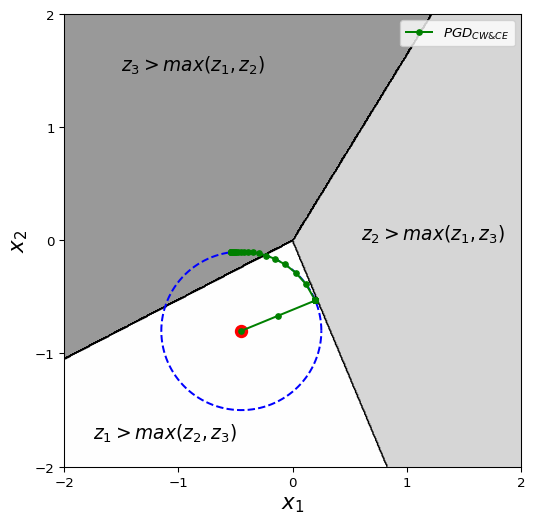

In [7]:
# this is for plotting purposes 
circle = np.array([[0,0]])
eps = 0.7 

for theta in np.arange(0,2*PI,0.01):
    points = np.array([[eps*cos(theta)+x0,eps*sin(theta)+y0]])
    circle = np.vstack((circle,points))
circle = circle[1:]

my_dpi = 96
plt.figure(figsize=(590/my_dpi,600/my_dpi), dpi=my_dpi)

col_bar = plt.contourf(X1, X2, pl, 60, cmap='Greys', alpha=0.4);
plt.contour(col_bar, cmap=None , levels=[0,1,2,3,4], colors='k', linewidths=(1,));
    
plt.plot(x0,y0,'ro',markersize=9);
plt.plot(circle[:,0],circle[:,1],'b--',markersize=6);
plt.plot(points_cwce[:,0],points_cwce[:,1],'go-',markersize=4, label=r'$PGD_{CW&CE}$');

plt.legend();
plt.text(-1.75,-1.75, r'$z_1 > max(z_2,z_3)$', fontsize=14)
plt.text(-1.5, 1.5, r'$z_3 > max(z_1,z_2)$', fontsize=14)
plt.text(0.6,0, r'$z_2 > max(z_1,z_3)$', fontsize=14)
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.xlabel("$x_1$",fontsize=16);
plt.ylabel("$x_2$",fontsize=16);